In [1]:
!pip install pytorch_lightning
!pip install comet_ml
!pip install lpips
!pip install pytorch-msssim


import os
import comet_ml
import torch
import math
import cv2
import glob
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.loggers import CometLogger
from PIL import Image
from models import RRDBNet
from utils import rgb2ycbcr, calc_psnr, calc_ssim

You should consider upgrading via the '/home/ubuntu/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ubuntu/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ubuntu/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ubuntu/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
from models import RRDBKDNet

In [3]:
from argparse import Namespace
hparams = {"in_nc": 3, 
           "out_nc": 3,
           "nf": 64,
           "nb": 23,
           "gc": 32,
           "nf_shrink": 1,
           "nb_shrink": 2,
           "gc_shrink": 1,
           "train_criterions":
               {
               "l1": 1.0},
           "val_criterions":
               {"l1": 1.0},
           "feature_matching": ("vanilla", 10.0),
           "gt_criterions": {"l1": 1.0},
           "lr": 0.0003,
           "train_batch_size": 4,
           "val_batch_size": 1,
           "num_workers": 4,
           "orig_checkpoint_path": './RRDB_PSNR_x4.pth'
           }
hparams = Namespace(**hparams)

In [5]:
!ls ./comet-default/794adc969fee484c87f170bfb562e88c/checkpoints/epoch=242-step=12149.ckpt

'./comet-default/794adc969fee484c87f170bfb562e88c/checkpoints/epoch=242-step=12149.ckpt'


In [16]:
#pl_model = RRDBKDNet(hparams)
pl_model = RRDBKDNet.load_from_checkpoint('./comet-default/794adc969fee484c87f170bfb562e88c/checkpoints/epoch=242-step=12149.ckpt')

<class 'dict'>


In [17]:
torch.save(pl_model.student_model.state_dict, "/home/ubuntu/KD_ESRGAN/student.pth")
torch.save(pl_model.teacher_model.state_dict, "/home/ubuntu/KD_ESRGAN/teacher.pth")

In [18]:
!du -h /home/ubuntu/KD_ESRGAN/*.pth

64M	/home/ubuntu/KD_ESRGAN/RRDB_ESRGAN_x4.pth
64M	/home/ubuntu/KD_ESRGAN/RRDB_PSNR_x4.pth
64M	/home/ubuntu/KD_ESRGAN/interp_00.pth
64M	/home/ubuntu/KD_ESRGAN/interp_01.pth
64M	/home/ubuntu/KD_ESRGAN/interp_02.pth
64M	/home/ubuntu/KD_ESRGAN/interp_05.pth
64M	/home/ubuntu/KD_ESRGAN/interp_09.pth
31M	/home/ubuntu/KD_ESRGAN/student.pth
65M	/home/ubuntu/KD_ESRGAN/teacher.pth


In [31]:
inputs = torch.randn(1, 3, 256, 256).cuda()
pl_model.student_model.cuda();
pl_model.teacher_model.cuda();

In [32]:
torch.cuda.empty_cache()

In [33]:
%%timeit
pl_model.student_model(inputs)

102 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
%%timeit
pl_model.teacher_model(inputs)

100 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [57]:
!du -h /home/ubuntu/KD_ESRGAN/*.pth

64M	/home/ubuntu/KD_ESRGAN/RRDB_ESRGAN_x4.pth
64M	/home/ubuntu/KD_ESRGAN/RRDB_PSNR_x4.pth
64M	/home/ubuntu/KD_ESRGAN/interp_00.pth
64M	/home/ubuntu/KD_ESRGAN/interp_01.pth
64M	/home/ubuntu/KD_ESRGAN/interp_02.pth
64M	/home/ubuntu/KD_ESRGAN/interp_05.pth
64M	/home/ubuntu/KD_ESRGAN/interp_09.pth
15M	/home/ubuntu/KD_ESRGAN/student.pth
65M	/home/ubuntu/KD_ESRGAN/teacher.pth


In [7]:
from datasets import DIV2K
from torch.utils.data.dataloader import DataLoader

train_dataset = DIV2K('/home/ubuntu/datasets/DIV2K', mode="train")
val_dataset = DIV2K('/home/ubuntu/datasets/DIV2K', mode="val")

train_loader = DataLoader(train_dataset, batch_size=hparams.train_batch_size, shuffle=True, num_workers=hparams.num_workers)
val_loader = DataLoader(val_dataset, batch_size=hparams.val_batch_size, shuffle=True, num_workers=hparams.num_workers)

In [8]:
from pytorch_lightning.callbacks import ModelCheckpoint

experiment = comet_ml.Experiment(
    api_key="NT3eAb24jop7ywUz264pXFCHj",
    project_name="KDESRGAN",
)

comet_logger = CometLogger(
    api_key=experiment.api_key,
    rest_api_key=experiment.api_key,
)

checkpoint_callback = ModelCheckpoint(
    monitor='val_psnr',
    save_top_k=3,
    mode='max',
)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/averagename/kdesrgan/03fe99767bd74fb5a108e642c1ac22a9

CometLogger will be initialized in online mode


In [9]:
trainer = pl.Trainer(gpus=1, logger=[comet_logger], callbacks=[checkpoint_callback], log_every_n_steps=20, min_epochs=400, accumulate_grad_batches=4)
trainer.fit(pl_model, train_loader, val_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/averagename/kdesrgan/03fe99767bd74fb5a108e642c1ac22a9
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (11 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     os packages              : 1
COMET INFO: ---------------------------
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/averagename/general/794adc969fee484c87f170bfb562e88c


  | Name          | Type    | Params
------------------------------------------
0 | teacher_model | RRDBNet | 16.7 M
1 | student_model | RRDBNet | 8.1 M 
-----------------

(516, 2058, 3)
(132, 262, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


(516, 4114, 3)
(132, 522, 3)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(516, 4114, 3)
(132, 522, 3)


/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/averagename/general/794adc969fee484c87f170bfb562e88c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     feature_mathing_loss [771] : (0.002621753141283989, 0.039434514939785004)
COMET INFO:     l1 [771]                   : (0.0030496406834572554, 0.03229235112667084)
COMET INFO:     l1_gt [771]                : (0.010111185722053051, 0.06676196306943893)
COMET INFO:     loss [6169]                : (0.010252425447106361, 0.13261762261390686)
COMET INFO:     train_batch_loss [771]     : (0.04028338938951492, 0.49271926283836365)
COMET INFO:     val_psnr [308]             : (28.518900151262137, 30.31700032482162)
COMET INFO:   Parameters:
COMET INFO:     feature_matching     : ('vanilla', 10.0)
COMET INFO:     gc                   : 32
COMET 

1

In [10]:
!ls ./comet-default/794adc969fee484c87f170bfb562e88c/checkpoints/epoch=242-step=12149.ckpt

'epoch=140-step=7049.ckpt'  'epoch=242-step=12149.ckpt'
'epoch=173-step=8699.ckpt'


In [11]:
test_dataset = DIV2K('/home/ubuntu/datasets/Set14/', mode="test")
test_dataloader = DataLoader(test_dataset)

In [12]:
print(len(test_dataset))

14


In [8]:
!ls /content/drive/My\ Drive/KD_ESRGAN/comet-default/e8743c397fd04924b8790d81713d5f69/checkpoints/

ls: cannot access '/content/drive/My Drive/KD_ESRGAN/comet-default/e8743c397fd04924b8790d81713d5f69/checkpoints/': No such file or directory


In [13]:
model = RRDBKDNet.load_from_checkpoint('./comet-default/794adc969fee484c87f170bfb562e88c/checkpoints/epoch=242-step=12149.ckpt')
trainer = pl.Trainer(gpus=1)
trainer.test(model, test_dataloaders=test_dataloader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


<class 'dict'>


/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/ubuntu/KD_ESRGAN/utils.py:62: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  return compare_ssim(img, rec)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'psnr': 28.241064071655273, 'ssim': 0.7810201644897461}
--------------------------------------------------------------------------------


[{'psnr': 28.241064071655273, 'ssim': 0.7810201644897461}]

In [39]:
from collections import OrderedDict
alpha = 0.00

net_PSNR_path = './RRDB_PSNR_x4.pth'
net_ESRGAN_path = './RRDB_ESRGAN_x4.pth'
net_interp_path = './interp_{:02d}.pth'.format(int(alpha*10))

net_PSNR = torch.load(net_PSNR_path)
net_ESRGAN = torch.load(net_ESRGAN_path)
net_interp = OrderedDict()

print('Interpolating with alpha = ', alpha)

for k, v_PSNR in net_PSNR.items():
    v_ESRGAN = net_ESRGAN[k]
    net_interp[k] = (1 - alpha) * v_PSNR + alpha * v_ESRGAN

torch.save(net_interp, net_interp_path)

Interpolating with alpha =  0.0


In [40]:
from argparse import Namespace
hparams = {"in_nc": 3, 
           "out_nc": 3,
           "nf": 64,
           "nb": 23,
           "gc": 32,
           "nf_shrink": 1,
           "nb_shrink": 2,
           "gc_shrink": 1,
           "train_criterions":
               {
               "lpips": 0.5,
               "l1": 1.0},
           "val_criterions":
               {"l1": 1.0},
           "feature_matching": ("vanilla", 1.0),
           "gt_criterions": {"l1": 1.0},
           "lr": 0.0003,
           "train_batch_size": 4,
           "val_batch_size": 1,
           "num_workers": 4,
           "orig_checkpoint_path": './interp_00.pth'
           }
hparams = Namespace(**hparams)

model = RRDBKDNet(hparams)
trainer = pl.Trainer(gpus=1)
trainer.test(model, test_dataloaders=test_dataloader)

<class 'dict'>
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Loading model from: /home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/lpips/weights/v0.1/vgg.pth



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'psnr': 28.721750259399414, 'ssim': 0.7906225323677063}
--------------------------------------------------------------------------------


[{'psnr': 28.721750259399414, 'ssim': 0.7906225323677063}]

In [ ]:
%cd /content/drive/My\ Drive/KD_ESRGAN/

/content/drive/My Drive/KD_ESRGAN


In [ ]:
from models import ESRGAN

from argparse import Namespace
hparams = {"in_nc": 3, 
           "out_nc": 3,
           "nf": 64,
           "nb": 23,
           "gc": 32,
           "nf_shrink": 1,
           "nb_shrink": 4,
           "gc_shrink": 1,
           "criterion": "mse",
           "lr": 0.0001,
           "train_batch_size": 4,
           "val_batch_size": 1,
           "num_workers": 4,
           "orig_checkpoint_path": '/content/drive/My Drive/RRDB_ESRGAN_x4.pth'
           }
hparams = Namespace(**hparams)

In [ ]:
net = ESRGAN(hparams)

In [ ]:
from datasets import DIV2K
from torch.utils.data.dataloader import DataLoader

train_dataset = DIV2K('/content/drive/My Drive/DIV2K', train=True, distill=False)
val_dataset = DIV2K('/content/drive/My Drive/DIV2K', train=False, distill=True)
print(len(train_dataset))
train_loader = DataLoader(train_dataset, batch_size=hparams.train_batch_size, shuffle=True, num_workers=hparams.num_workers)
val_loader = DataLoader(val_dataset, batch_size=hparams.val_batch_size, shuffle=True, num_workers=hparams.num_workers)

800


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
trainer = pl.Trainer(gpus=1, log_every_n_steps=20, min_epochs=20, accumulate_grad_batches=4)
trainer.fit(net, train_loader, val_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name | Type          | Params
---------------------------------------
0 | g    | RRDBNet       | 16.7 M
1 | d    | Discriminator | 4.7 M 
---------------------------------------
21.4 M    Trainable params
0         Non-trainable params
21.4 M    Total params
85.567    Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [ ]:
import torchvision.transforms as transforms
from datasets import transform_to_torch, crop_image, transform_torch
from utils import torch2image
import matplotlib.pyplot as plt

In [ ]:
img_lr = cv2.imread('/content/drive/My Drive/DIV2K/DIV2K_valid_LR_bicubic/X4/0801x4.png', cv2.IMREAD_COLOR)
img_lr = transform_to_torch(img_lr)
cropped_lr, coords = transform_torch(img_lr)
res_lr = torch2image(cropped_lr)
print(res_lr.shape)
print(coords)
img_hr = cv2.imread('/content/drive/My Drive/DIV2K/DIV2K_valid_HR/0801.png', cv2.IMREAD_COLOR)
img_hr = transform_to_torch(img_hr)
cropped_hr = crop_image(img_hr, coords[0] * 4, coords[1] * 4, coords[2] * 4, coords[3] * 4)
res_hr = torch2image(cropped_hr)
print(res_hr.shape)

(128, 128, 3)
(128, 375, 128, 128)
(512, 512, 3)


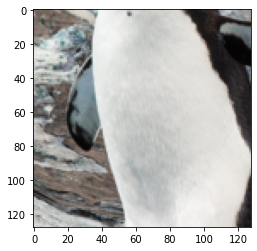

In [ ]:
plt.imshow(res_lr)

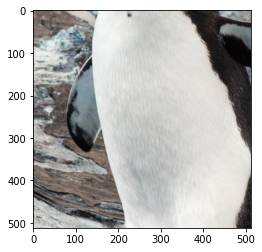

In [ ]:
plt.imshow(res_hr)

In [ ]:
img_cropped = crop_image(img, crop_t[0], crop_t[1], crop_t[2], crop_t[3])

In [ ]:
img_cropped.shape

torch.Size([3, 128, 128])

In [8]:
from models import RRDBNet

In [67]:
model = RRDBNet(3, 3, 64, 23)
model.load_state_dict(torch.load('./RRDB_ESRGAN_x4.pth'))

<All keys matched successfully>

In [49]:
model.cuda()
model.eval()

RRDBKDNet(
  (teacher_model): RRDBNet(
    (conv_first): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (RRDB_trunk): Sequential(
      (0): RRDB(
        (RDB1): ResidualDenseBlock_5C(
          (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv3): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv4): Conv2d(160, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv5): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
        )
        (RDB2): ResidualDenseBlock_5C(
          (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv3): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [54]:
from PIL import Image
from datasets import transform_to_torch
import matplotlib.pyplot as plt

image = Image.open('/home/ubuntu/comic.png').convert("RGBA")
image = np.array(image)[:, :, [2, 1, 0]]
image = transform_to_torch(image)

In [55]:
import numpy as np
np.array(image).shape

(3, 90, 62)

In [56]:
%matplotlib inline
result, _ = model(image.unsqueeze(0).cuda())

In [57]:
print(torch.max(result))
print(torch.min(result))


tensor(1.0724, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0047, device='cuda:0', grad_fn=<MinBackward1>)


In [58]:
from utils import torch2image
img = torch2image(result)[:, :, ::-1]

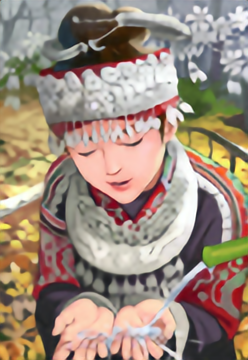

In [59]:
from PIL import Image
pil = Image.fromarray(img)
pil

In [18]:
from PIL import Image
from datasets import transform_to_torch
import matplotlib.pyplot as plt
from datasets import transform_to_torch, transform_torch
from utils import torch2image

def show_crop_teacher_student(image_path, model):
    image = Image.open(image_path).convert("RGBA")
    gt = np.array(Image.open(image_path.replace('LR', 'HR')))
    image = np.array(image)[:, :, [2, 1, 0]]
    image = transform_to_torch(image)
    if image.shape[1] > 128 and image.shape[2] > 128:
        crop, _ = transform_torch(image)
    else:
        crop = image
    crop = crop.unsqueeze(0).cuda()
    
    result_student, _ = model(crop)
    result_teacher, _ = model.teacher_model(crop)
    
    img_student = torch2image(result_student)[:, :, ::-1]
    img_teacher = torch2image(result_teacher)[:, :, ::-1]
    
    plot = np.concatenate([img_student, img_teacher, gt], axis=1)
    plt.figure(figsize=(30, 30))
    plt.imshow(plot)

In [33]:
!ls ./comet-default/13cfbaa082ac47aaa9f60382711a5376/checkpoints/epoch=282-step=14149.ckpt

'epoch=161-step=8099.ckpt'   'epoch=282-step=14149.ckpt'
'epoch=272-step=13649.ckpt'


In [34]:
torch.cuda.empty_cache()
del model
#model = RRDBKDNet.load_from_checkpoint('./comet-default/794adc969fee484c87f170bfb562e88c/checkpoints/epoch=242-step=12149.ckpt')
model = RRDBKDNet.load_from_checkpoint('./comet-default/13cfbaa082ac47aaa9f60382711a5376/checkpoints/epoch=282-step=14149.ckpt')
model.cuda();
model.eval();

<class 'dict'>


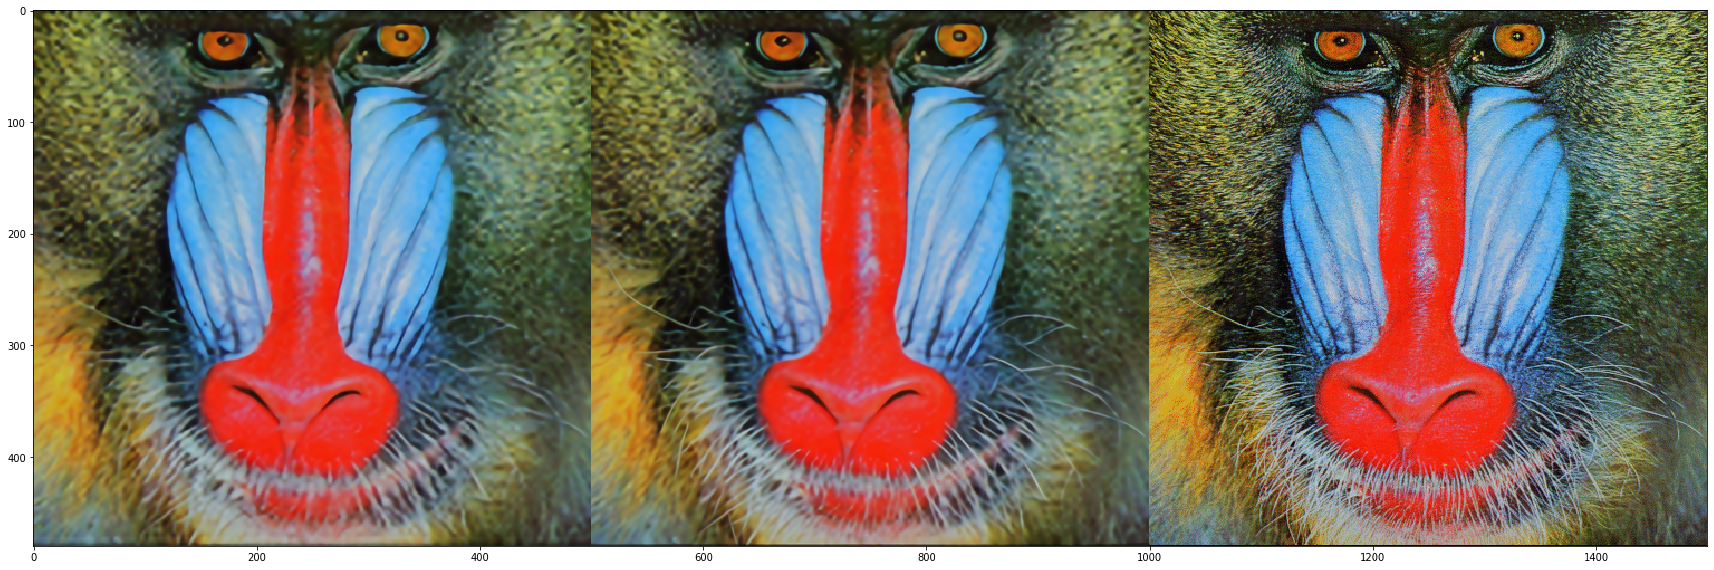

In [35]:
show_crop_teacher_student('/home/ubuntu/datasets/Set14/valid_LR/img_001_SRF_4_LR.png', model)

In [60]:
from utils import calc_psnr
gt = Image.open('/home/ubuntu/datasets/Set14/valid_HR/img_005_SRF_4_HR.png')
gt = np.array(gt)

In [61]:
calc_psnr(img, gt)

23.3243672773294

In [1]:
import torch
import torch.nn as nn

In [4]:
layers = [nn.Conv2d(3, 10, 3), nn.Conv2d(10, 20, 3)]
seq = nn.Sequential(*layers)

In [8]:
out = torch.randn(1, 3, 20, 20)
for block in seq:
    out = block(out)
print(out.shape)

torch.Size([1, 20, 16, 16])


In [12]:
from models import RRDB
import functools
from models import make_layer

RRDB_block_f = functools.partial(RRDB, nf=32, gc=32)
RRDB_trunk = make_layer(RRDB_block_f, 2)

In [15]:
for block in RRDB_trunk:
    print(block)

RRDB(
  (RDB1): ResidualDenseBlock_5C(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(160, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (RDB2): ResidualDenseBlock_5C(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(160, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (RDB3): Re